We generate pseudo-observations according to the following model.

$$ Y = MX + \epsilon,$$

where $X \sim \mathcal{N}(0,\mathbb{I})$ is a proxy for 'neural activity', $Y$ are the 'observed variables' (1d), and $\epsilon \sim \mathcal{N}(0,??)$ is a noise term that limits the predictive power of a linear model.

Instead of directly setting the variance of $\epsilon$, we set a desired r2 value, and the program works out the according variance.

Note that $X$ is a (number of regressors*number_of_datapoints)-size matrix, while $Y$ is (1 x number_of_datapoints)


We initialise $M$ as follows:

    M = rand(inf.num_regressors)'


On each day we update $M$ in a non-trivial way. Let $\Delta M$ signify the inter day update. First note that
$$ Y^d = (M + \Delta M)X + \epsilon^d. $$

We want the variance of $Y$ on any given day to be constant (i.e. independent of day). We assume that the variance of $\epsilon^d$ is constant over days. So we require

$$ Var(M + \Delta M)X = Var(MX) $$. Note that $X$ is mean zero so this equates to 

$$ \mathbb{E}[ (M+\Delta M)XX^T(M+\Delta M)^T] = \mathbb{E}[ MXX^TM^T].$$

Since both $M$ and $\Delta M$ are uncorrelated with $X$, this gives, in expectation

$$ \mathbb{E}[\|(M+\Delta M)\|_2^2] = \mathbb{E}[\|M\|_2^2.$$

Therefore, $\Delta M$ has to be anticorrelated with $M$. Specifically, we require
$$ \Delta M^TM = - \frac{\|\Delta M\|^2_2}{2}.$$



Now we need to determine the magnitude of $\Delta M$. By definition

$$ 1 - \mathcal{R}^2 = \frac{Var(\Delta MX + \epsilon)}{Var(Y)}, $$

where $MX$ is the predictor, and the numerator is the mean square error of $Y - predictor$. 

We can replace $Var(Y^d)$ with $Var(Y^{d-1})$ as the previous constraints on $\Delta M$ have ensured this variance is constant over days.

This gives 

$$ Var(\Delta M X) \approx (1-R^2)Var(Y^{d-1}) -  Var(\epsilon) $$


How do we relate $ Var(\Delta M X) $ to $\| \Delta M \|_2^2$ ? Well,

$$  Var(\Delta M X) = \frac{1}{D} \mathbb{E}[\Delta M X X^T \Delta M^T] $$

$$  Var(\Delta M X) \approx \frac{Tr(XX^T)}{rD}  \| \Delta M^T \|_2^2 $$

Overall,

$$ \| \Delta M^T \|_2^2 = \frac{rD}{Tr(XX^T)}\Big[ (1-R^2)Var(Y^{d-1}) -  Var(\epsilon)   \Big] $$



So we have a quadratic and a linear constraint on $\Delta M$, of the form
$$ \Delta M^T \Delta M = K, $$
$$ \Delta M^TM = -\frac{K}{2}, $$

where $K$ is given above.

We generate a Gaussian random $\Delta M$ candidate, get the orthogonal and parallel components relative to $M$, and rescale them so that the above constraints are satisfied.


Meanwhile, how big should $\epsilon^d$ be? We want the $\mathcal{R}^2$ of $Y$, wrt the model $MX$, to be predetermined. For a fixed value of (within day) $\mathcal{R}^2$, we get

$$ 1 - \mathcal{R}^2 = \frac{Var(\epsilon)}{Var(MX) + Var(\epsilon)} $$


$$  Var(\epsilon) = \frac{1-\mathcal{R}^2}{\mathcal{R}^2} Var(MX). $$



We then generate a new $\epsilon$, which is gaussian noise, but normalised so the $R^2$ between $Y$ and $RX$ is fixed (by the constant r2 below).

In [1]:
include("concatenated_decoder_numerics.jl")
using Plots

const within_day_R2 = 0.73
const between_day_R2 = 0.6
const num_data_per_day = 5000
const num_regressors = 60
;

We package up the above variables into a struct:

In [2]:
inf = generalInfo(num_data_per_day, num_regressors, within_day_R2, between_day_R2)

generalInfo("unnamed", 5000, 60, 0.73, 0.6, nothing)

Now we can initalise a day. This is is initialised with the dimensions and r2 provided in inf.

In [3]:
d1 = initialise_day(inf)
println(fieldnames(typeof(d1)))

(:M, :X, :Y)


$R$ is the vector of 'true' regressor coefficients. $Y$ is generated such that it has the R2 demanded by inf.

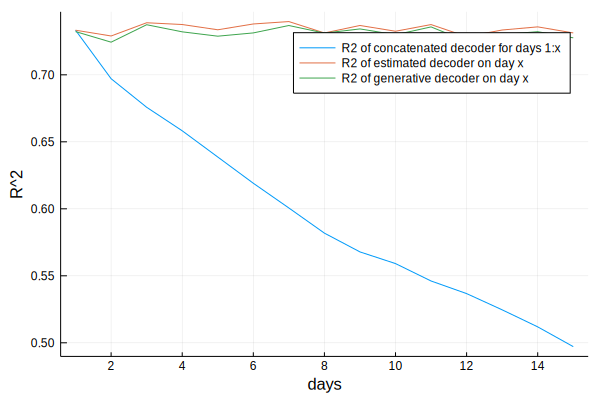

In [4]:
const number_of_days = 15
days = Array{dailyStore,1}(undef, number_of_days)
days = fill_days!(days, inf, d1);

concatenated_R2_vec = concat_R2_over_days(days)
est_R2_per_day = get_est_R2.(days)
true_R2_per_day = get_true_R2.(days)

p = plot(concatenated_R2_vec; label="R2 of concatenated decoder for days 1:x", ylabel="R^2", xlabel="days")
plot!(est_R2_per_day; label="R2 of estimated decoder on day x")
plot!(true_R2_per_day; label="R2 of generative decoder on day x")

 Note that the estimated decoder works better than the true decoder often: there is so much redundancy in the space of decoders that the estimated decoder can overfit the noise $\epsilon$

In [5]:
y_changes = [norm(el.Y - elp.Y) for (elp,el) in zip(days[1:end-1], days[2:end])]
r_norm_changes = [norm(el.R) for el in days]

q = plot(y_changes, label = "norm of change in Y per day")
plot!(r_norm_changes, label = "norm of R")

ErrorException: type dailyStore has no field R

In [6]:

savefig(p, "concat_deg.pdf")

In [7]:
concatenated_R2_vec/concatenated_R2_vec[1]

15-element Array{Float64,1}:
 1.0               
 0.9506188703936549
 0.92153731077341  
 0.8976140162473304
 0.8709220163070269
 0.8442204398310118
 0.8190541896346998
 0.7934512177759299
 0.774340657371206 
 0.7624474128594948
 0.7447477434571697
 0.7319049347146348
 0.7153917799364694
 0.6980444885799868
 0.6779217080831014